In [5]:
import csv
from operator import itemgetter
import networkx as nx
from networkx.algorithms import community
import networkx.algorithms.community as nx_comm
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.pyplot import figure
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep

In [4]:
!pip install ndlib

     |████████████████████████████████| 96 kB 1.5 MB/s eta 0:00:011
     |████████████████████████████████| 428 kB 8.6 MB/s eta 0:00:01
  Attempting uninstall: tornado
    Found existing installation: tornado 5.0.2
    Uninstalling tornado-5.0.2:
      Successfully uninstalled tornado-5.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-git 0.11.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.1.0 which is incompatible.


In [6]:
import pandas as pd 
import numpy as np
import itertools  
from itertools import chain

# **Data Pre-Process**

In [82]:
# Reading the checkins dataset
check = pd.read_csv("../input/network/checkins.txt", delimiter = "\t", names=["User", "Check-in-time", "Latitude", "Longitude", "Location id"])

#check['Check-in-time'] = pd.to_datetime(check['Check-in-time']).dt.tz_convert(None)
check.head()

,User,Check-in-time,Latitude,Longitude,Location id
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878


**Splitting the Check-in-time Data into two columns**
*     Check_In_Date
*     Check_In_Time

**Exatrcting the data for the month of July**


In [83]:
check[['Check_In_Date','Check_In_Time']] = check['Check-in-time'].str.split('T',expand=True)
check = check.drop(columns=['Check-in-time'])

# Exatrcting the data for the month of July
july_check = check[check['Check_In_Date'].str.contains("2010-07")]
july_check

,User,Latitude,Longitude,Location id,Check_In_Date,Check_In_Time
127,0,30.267910,-97.749312,21714,2010-07-31,16:53:09Z
128,0,30.251031,-97.754092,49904,2010-07-31,01:49:44Z
129,0,30.266240,-97.745908,9225,2010-07-29,23:59:07Z
130,0,30.270734,-97.753703,9241,2010-07-29,17:23:56Z
131,0,30.201557,-97.667127,9410,2010-07-26,16:37:17Z
...,...,...,...,...,...,...
1458377,9993,38.582918,-90.490548,146539,2010-07-04,15:42:12Z
1458378,9993,38.593260,-90.497497,130618,2010-07-04,15:27:24Z
1458379,9993,38.593763,-90.555972,407945,2010-07-03,02:12:52Z
1458380,9993,38.593160,-90.557285,123750,2010-07-03,02:04:42Z


In [ ]:
#Checking for node having max counts in location ID**
#july_check['Location id'].value_counts()

*Selecting any 5 location ID and creating a dataframe called "data_final"*

In [84]:
# Data for July for 5 location ID's 
data_final = july_check.loc[july_check['Location id'].isin(['19542','9410', '10259', '9241', '304939'])]

# Removing Z and colon from the Check-in-Time
data_final['Check_In_Time'] = data_final['Check_In_Time'].str.replace('Z','')
data_final['Check_In_Time'] = data_final['Check_In_Time'].str.replace(':','')

# Converting string to integer
data_final['Check_In_Time'] = data_final['Check_In_Time'].astype(str).astype(int)
data_final.head(200)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,User,Latitude,Longitude,Location id,Check_In_Date,Check_In_Time
130,0,30.270734,-97.753703,9241,2010-07-29,172356
131,0,30.201557,-97.667127,9410,2010-07-26,163717
143,0,30.201557,-97.667127,9410,2010-07-21,183827
4250,22,30.201557,-97.667127,9410,2010-07-12,224958
4254,22,30.201557,-97.667127,9410,2010-07-10,20357
...,...,...,...,...,...,...
277016,878,30.201557,-97.667127,9410,2010-07-25,122425
277029,878,30.201557,-97.667127,9410,2010-07-21,43551
277049,878,30.201557,-97.667127,9410,2010-07-16,160347
286715,909,32.897462,-97.040348,10259,2010-07-03,214459


**OPTIONAL STEP:** 

*Checking if the locationID has the same Longitude and Latitude*

In [ ]:
grup = data_final.groupby("Location id")

for i,j in grup:
    print(grup.get_group(i), "\n\n") 

**Dividing the July dataset in intervals of 4hours:**
* *00:00 - 4:00 --> Group A*
* *4:00 - 8:00 --> Group B*
* *8:00 - 12:00 --> Group C*
* *12:00 - 16:00 --> Group D*
* *16:00 - 20:00 --> Group E*
* *20:00 - 00:00 --> Group F*

In [85]:
# create a list of our conditions
conditions = [
    (data_final["Check_In_Time"] <= 40000),
    (data_final["Check_In_Time"] > 40000) & (data_final["Check_In_Time"] <= 80000),
    (data_final["Check_In_Time"] > 80000) & (data_final["Check_In_Time"] <= 120000),
    (data_final["Check_In_Time"] > 120000) & (data_final["Check_In_Time"] <= 160000),
    (data_final["Check_In_Time"] > 160000) & (data_final["Check_In_Time"] <= 200000),
    (data_final["Check_In_Time"] > 200000) 
    ]

# create a list of the values we want to assign for each condition
values = ['Group_A', 'Group_B', 'Group_C', 'Group_D', 'Group_E', 'Group_F']

# create a new column and use np.select to assign values to it using our lists as arguments
data_final['Time Intervals'] = np.select(conditions, values)



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


*Creating a list of tuples of each User present on the same location at the same date within a time interval*

In [117]:
# Grouping the data
grouped_df = data_final.groupby(["Check_In_Date", "Time Intervals", "Location id"])

# Initializing the list
final_data = []
tupl = []

# Extracting the grouped UserID's and storing it as list 
for key,item in grouped_df:
    a_group = grouped_df.get_group(key)
    Name_ID = a_group["User"].tolist()

    final_data.append(Name_ID)
    
# Creating tuples of the users interacting within the same interval 
    for element in final_data:
        if len(element) > 1:
            element = list(itertools.combinations(element, 2))
        else:
            element = list(itertools.combinations(element, 1))
        tupl.append(element)
        #print(element)
    
tupl = list(chain.from_iterable(tupl))


***Creating the CSV file for the pre-processed Data***

In [ ]:
# Creating a DataFrame of the Users interacted between the time intervals in the month of July
Nodes_data = pd.DataFrame(tupl, columns = ["User1", "User2"])

# Checking the shape of the dataFrame
print("The shape of the DataFrame is: \n", Nodes_data.shape)

# Saving the DataFrame as csv file
Nodes_data.to_csv('Final_Nodes_Data.csv', index=False)

# ***Plotting Graph***

*NetworkX Simulations*

In [53]:
Nodes_data = pd.read_csv("../input/finoutput/Final_Nodes_Data.csv") #Reading CSV
print("\n Shape of the original DataFrame (before removing duplicates) : " , Nodes_data.shape)

# Checking the number of NAN values in the dataframe
Nan_val = Nodes_data['User2'].isna().sum()
print("\n Number of NaN values: " , Nan_val)

Nodes_data = Nodes_data.dropna() # Removing the NaN value rows
print("\n Shape of the dataframe after dropping NaN values:" , Nodes_data.shape)

# Creating a dataframe called Weight_nodes containing the count of every tupple interaction
Weight_nodes = Nodes_data.groupby(['User1', 'User2']).size().reset_index(name='count')
Weight_nodes = Weight_nodes.astype(int)
print("\n Shape of the new Weight_nodes DataFrame: " , Weight_nodes.shape)

#print("\n \n Weight Node" , Weight_nodes.head())


 Shape of the original DataFrame (before removing duplicates) :  (230560, 2)

 Number of NaN values:  49966

 Shape of the dataframe after dropping NaN values: (180594, 2)

 Shape of the new Weight_nodes DataFrame:  (686, 3)


In [51]:
#Weight_nodes.head()

,User1,User2,count
0,0,41.0,82
1,0,3742.0,163
2,0,4904.0,82
3,0,7451.0,163
4,22,3469.0,338


***Graph Plottin*g**

In [ ]:
# store pairs to a list of tuples
#tuples = [tuple(x) for x in Nodes_data_.values]

# set up a graph and show it
#G = nx.DiGraph()
#G.add_edges_from(tuples)
#nx.draw_networkx(G)
#plt.xticks([], [])
#plt.yticks([], [])
#plt.show()

{0: Text(-0.03631987403626207, -0.02440769750630577, '0'),
 41: Text(-0.11713731663178752, -0.05956979766120386, '41'),
 3742: Text(-0.007377534217408249, 0.023689844987220165, '3742'),
 4904: Text(-0.0176715202484363, -0.038288801279226486, '4904'),
 7451: Text(0.03562203690202446, -0.012274678036844424, '7451'),
 22: Text(0.3612614679773034, 0.3274649741881824, '22'),
 3469: Text(0.3087629614645344, 0.2792443074988896, '3469'),
 3675: Text(0.4022081904291467, 0.3649598722626763, '3675'),
 3914: Text(0.3711669286901611, 0.3190418427643785, '3914'),
 4158: Text(0.3479966955793368, 0.3111250000687789, '4158'),
 819: Text(-0.1298288870711444, -0.05182987705109396, '819'),
 2241: Text(-0.16539449572044507, -0.07119336684188148, '2241'),
 3988: Text(-0.13412950476471072, -0.04092167581542957, '3988'),
 5270: Text(-0.1820582292722042, -0.06673984239984077, '5270'),
 5717: Text(-0.18275140510269178, -0.1128052465006938, '5717'),
 5736: Text(-0.1678883989616306, -0.05609489567887935, '5736'),

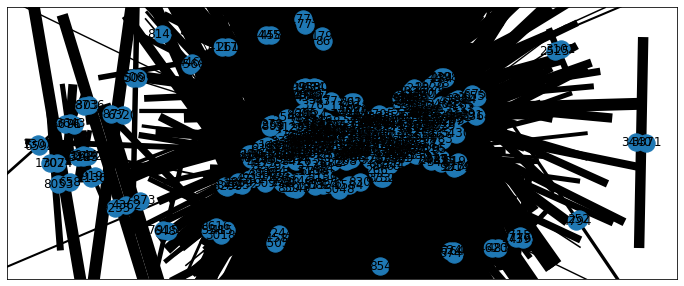

In [129]:
G = nx.from_pandas_edgelist(Weight_nodes,'User1','User2', edge_attr='count')
durations = [i['count'] for i in dict(G.edges).values()]
labels = [i for i in dict(G.nodes).keys()]
labels = {i:i for i in dict(G.nodes).keys()}

fig, ax = plt.subplots(figsize=(12,5))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, ax = ax)
nx.draw_networkx_edges(G, pos, width=durations, ax=ax)
nx.draw_networkx_labels(G, pos, labels, ax=ax)

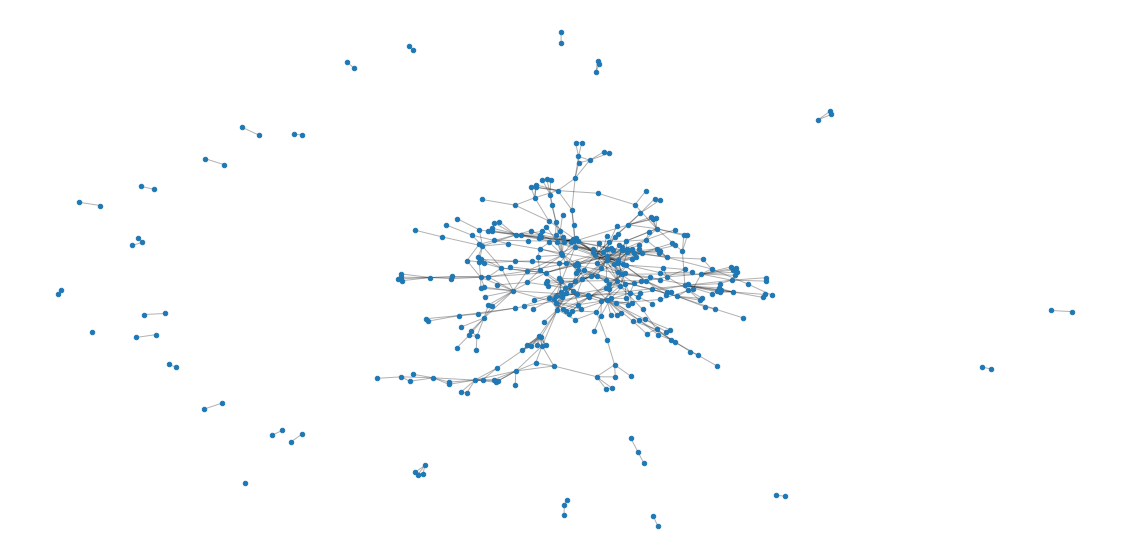

In [130]:
a4_dims = (20, 10)
fig, ax = plt.subplots(figsize = a4_dims)
plt.axis('off')
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha = 0.3)
plt.show()

# ***Simmulations***

***Infection Curve***

In [56]:
def get_infection_curve(G, infection_rate, recovery_rate, n_iter):
    
    model = ep.SIRModel(G)
    no_nodes = G.number_of_nodes()
    
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', infection_rate)
    cfg.add_model_parameter('gamma', recovery_rate)
    cfg.add_model_parameter("fraction_infected", 0.05)
    model.set_initial_status(cfg)
    
    times = np.array(range(n_iter))
    
    iterations = model.iteration_bunch(n_iter)
    infected = np.array([iterations[i]['node_count'][1] for i in range(n_iter)])/no_nodes
    recovered = np.array([iterations[i]['node_count'][2] for i in range(n_iter)])/no_nodes
    return times, infected, recovered

curve = get_infection_curve(G, 0.01,0.005, 500)

100%|██████████| 500/500 [00:00<00:00, 1042.98it/s]


In [57]:
def get_infection_curve(G, infection_rate, recovery_rate, n_iter):
    
    model = ep.SIRModel(G)
    no_nodes = G.number_of_nodes()
    
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', infection_rate)
    cfg.add_model_parameter('gamma', recovery_rate)
    cfg.add_model_parameter("fraction_infected", 0.05)
    model.set_initial_status(cfg)
    
    times = np.array(range(n_iter))
    
    iterations = model.iteration_bunch(n_iter)
    infected = np.array([iterations[i]['node_count'][1] for i in range(n_iter)])/no_nodes
    recovered = np.array([iterations[i]['node_count'][2] for i in range(n_iter)])/no_nodes
    return times, infected, recovered

curve = get_infection_curve(G, 0.01,0.005, 500)

100%|██████████| 500/500 [00:00<00:00, 1054.25it/s]


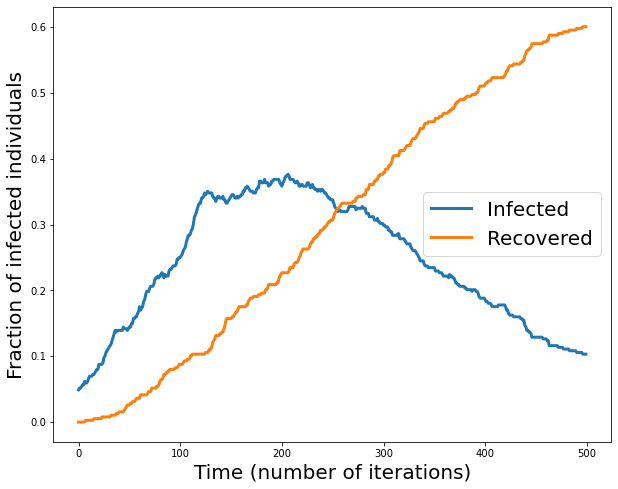

In [58]:
a4_dims = (10, 8)
fig, ax = plt.subplots(figsize=a4_dims)

plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

ax.plot(curve[0],curve[1], label = 'Infected', linewidth = 3)
ax.plot(curve[0],curve[2], label = 'Recovered', linewidth = 3)

plt.legend(loc = 'center right', fontsize=20)

**Reducing transmission rate**

*explore the effect of reducing the transmission rate between individuals.*

100%|██████████| 500/500 [00:00<00:00, 1781.37it/s]


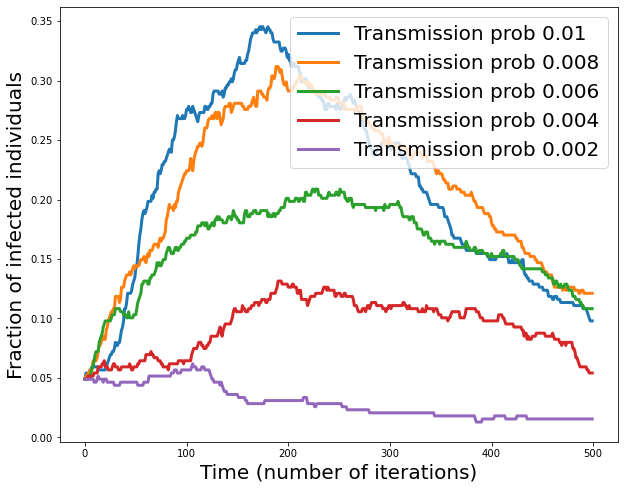

In [59]:
fig, ax = plt.subplots(figsize=a4_dims)

plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

betas = [0.01, 0.008, 0.006, 0.004, 0.002]

for i in range(5):
    curve = get_infection_curve(G, betas[i],0.005, 500)
    ax.plot(curve[0],curve[1], label = 'Transmission prob '+str(betas[i]), linewidth = 3)

plt.legend(loc = 'upper right', fontsize=20)
plt.show()

100%|██████████| 500/500 [00:00<00:00, 1529.57it/s]


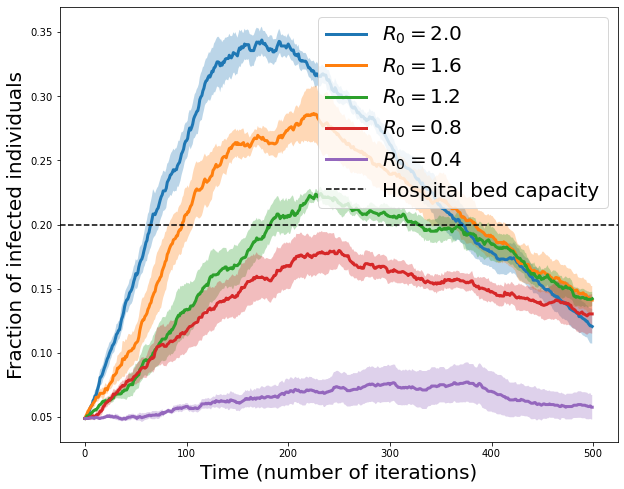

In [60]:
fig, ax = plt.subplots(figsize=a4_dims)

plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

betas = [0.01, 0.008, 0.006, 0.004, 0.002]
no_experiments = 5

for i in range(5):
    experiments = np.zeros((no_experiments,500),dtype=float)
    for ex in range(no_experiments):
        curve = get_infection_curve(G, betas[i],0.005, 500)
        experiments[ex]=curve[1]
    avg = np.mean(experiments,axis=0)
    std = np.std(experiments,axis=0)
    ax.plot(curve[0],avg, label = '$R_0=$'+str(betas[i]/0.005), linewidth = 3)
    ax.fill_between(curve[0],avg-0.5*std, avg + 0.5*std, alpha = 0.3)

plt.axhline(y=0.2,label='Hospital bed capacity',color='black',linestyle='--')
    
plt.legend(loc = 'upper right', fontsize=20)
plt.show()

***SIS model Scale Free Graph***

In [61]:
def get_SIS_infection_curve(G, infection_rate, recovery_rate, n_iter):
    
    model = ep.SISModel(G)
    no_nodes = G.number_of_nodes()
    
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', infection_rate)
    cfg.add_model_parameter('lambda', recovery_rate)
    cfg.add_model_parameter("fraction_infected", 0.05)
    model.set_initial_status(cfg)
    
    times = np.array(range(n_iter))
    
    iterations = model.iteration_bunch(n_iter)
    infected = np.array([iterations[i]['node_count'][1] for i in range(n_iter)])/no_nodes
    return times, infected

100%|██████████| 500/500 [00:01<00:00, 483.96it/s]


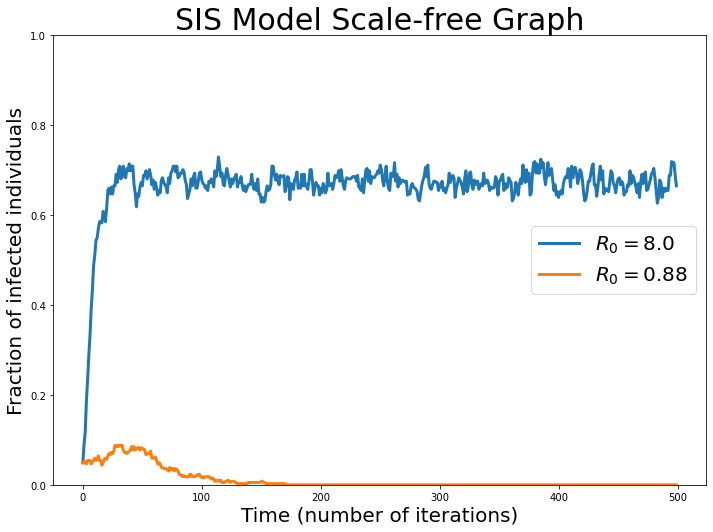

In [65]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)


plt.title("SIS Model Scale-free Graph", fontsize = 30)
plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylim(0,1)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

R0 = 2.0
curve1 = get_SIS_infection_curve(G, 0.1*R0, 0.1, 500)
ax.plot(curve1[0],curve1[1], label = '$R_0 = $'+str(R0*4), linewidth = 3)

R0 = 0.22
curve2 = get_SIS_infection_curve(G, 0.1*R0, 0.1, 500)
ax.plot(curve2[0],curve2[1], label = '$R_0 = $'+str(R0*4), linewidth = 3)

plt.legend(loc = 'center right', fontsize=20)
plt.show()

# SIR Model

In [68]:
def get_SIR_infection_curve(G, infection_rate, recovery_rate, n_iter):
    
    model = ep.SIRModel(G)
    no_nodes = G.number_of_nodes()
    
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', infection_rate)
    cfg.add_model_parameter('gamma', recovery_rate)
    cfg.add_model_parameter("fraction_infected", 0.05)
    model.set_initial_status(cfg)
    
    times = np.array(range(n_iter))
    
    iterations = model.iteration_bunch(n_iter)
    susceptible = np.array([iterations[i]['node_count'][0] for i in range(n_iter)])/no_nodes
    infected = np.array([iterations[i]['node_count'][1] for i in range(n_iter)])/no_nodes
    recovered = np.array([iterations[i]['node_count'][2] for i in range(n_iter)])/no_nodes
    return times, infected, recovered, susceptible

100%|██████████| 800/800 [00:00<00:00, 1212.79it/s]


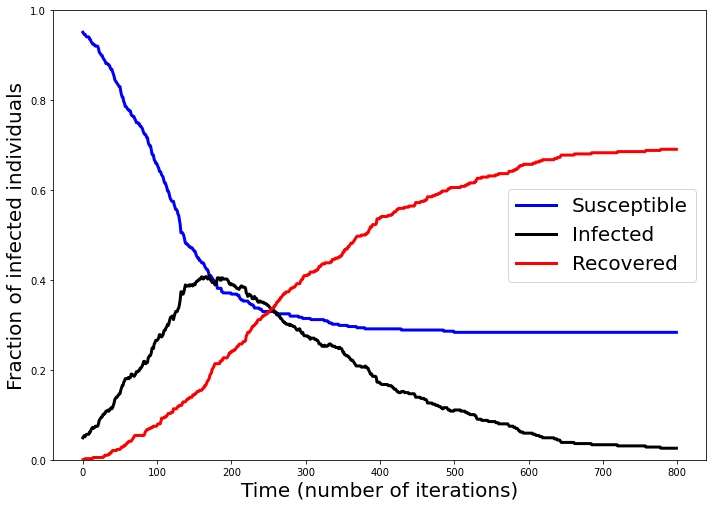

In [69]:
curve = get_SIR_infection_curve(G, 0.01,0.005, 800)

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.ylim(0,1)
plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

ax.plot(curve[0],curve[3], label = 'Susceptible', color='blue', linewidth = 3)
ax.plot(curve[0],curve[1], label = 'Infected', color = 'black', linewidth = 3)
ax.plot(curve[0],curve[2], label = 'Recovered', color = 'red', linewidth = 3)

plt.legend(loc = 'center right', fontsize=20)

*BETWEENESS CENTRALITY & NODE REMOVAL*

In [79]:
bet_centrality = nx.betweenness_centrality(G, normalized = True, 
                                              endpoints = False)
keys = np.fromiter(bet_centrality.keys(), dtype=float)
#print(keys)
#print("Dict: " , bet_centrality.keys())

[   0.   41. 3742. 4904. 7451.   22. 3469. 3675. 3914. 4158.  819. 2241.
 3988. 5270. 5717. 5736.   52.  536. 3139. 4165.   63.   85. 1108. 4361.
 5444. 7557.   66.  153. 5739.   73.  223.  779. 1120. 1346.   77. 1773.
   84.  510. 2066. 4700. 7525. 1665. 1768. 2244. 2926. 3030. 3172. 3574.
 6397.   86.  179.   88.  559. 3328.   91. 3643. 5676.   96.  124. 4234.
 4255. 8600.  376. 1453. 4936.  141.  375. 3380. 6112.  143.  268. 9096.
  158. 2505. 4244.  172. 3581. 4216. 6303.  191.  312. 2350.  197.  599.
 3837. 4756. 5268. 6262.  204. 7357. 7358.  243. 1703. 2283. 6278. 9643.
  252. 4794.  256. 3337.  261. 4117.  266.  326. 8752.  267.  515. 1941.
 3947. 8804. 9793.  278. 3129.  281.  501. 2141. 6425.  282.  283.  533.
 2612. 6546. 9275.  302. 1835. 2615. 2893. 3434. 3590. 7291.  304. 1243.
 8022.  547. 2518. 2637. 6319. 5338. 6827.  328. 2278. 2721.  335.  537.
  347. 1116. 2801. 4372. 4466.  355.  476.  577. 4383. 4397. 9192.  408.
 2739. 3476. 4664. 4738.  419. 5788.  434. 2681. 51

*NODE REMOVAL*

100%|██████████| 500/500 [00:00<00:00, 1137.45it/s]


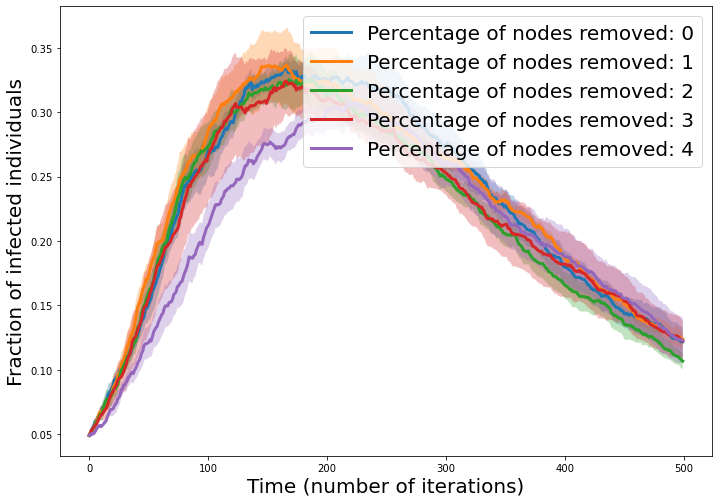

In [80]:
fig, ax = plt.subplots(figsize=a4_dims)

plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

perc = [0,1,2,3,4]
no_experiments = 5

ranks = keys

for i in range(5):
    H = G.copy()
    number = round(float(perc[i])*G.number_of_nodes()/100)
    top_nodes = ranks[:number]
    for n in top_nodes:
        H.remove_edges_from([(n,out) for out in G.neighbors(n)])
    experiments = np.zeros((no_experiments,500),dtype=float)
    for ex in range(no_experiments):
        curve = get_SIR_infection_curve(H, 0.01,0.005, 500)
        experiments[ex]=curve[1]
    avg = np.mean(experiments,axis=0)
    std = np.std(experiments,axis=0)
    ax.plot(curve[0],avg, label = 'Percentage of nodes removed: '+str(perc[i]), linewidth = 3)
    ax.fill_between(curve[0],avg-0.5*std, avg + 0.5*std, alpha = 0.3)
    
plt.legend(loc = 'upper right', fontsize=20)
plt.show()

*EIGENVECTOR CENTRALITY*

In [132]:
eig_centrality = nx.eigenvector_centrality(G)

keys_ei = np.fromiter(eig_centrality.keys(), dtype=float)
print(keys_ei)
print("Dict: " , eig_centrality.keys())

[   0.   41. 3742. 4904. 7451.   22. 3469. 3675. 3914. 4158.  819. 2241.
 3988. 5270. 5717. 5736.   52.  536. 3139. 4165.   63.   85. 1108. 4361.
 5444. 7557.   66.  153. 5739.   73.  223.  779. 1120. 1346.   77. 1773.
   84.  510. 2066. 4700. 7525. 1665. 1768. 2244. 2926. 3030. 3172. 3574.
 6397.   86.  179.   88.  559. 3328.   91. 3643. 5676.   96.  124. 4234.
 4255. 8600.  376. 1453. 4936.  141.  375. 3380. 6112.  143.  268. 9096.
  158. 2505. 4244.  172. 3581. 4216. 6303.  191.  312. 2350.  197.  599.
 3837. 4756. 5268. 6262.  204. 7357. 7358.  243. 1703. 2283. 6278. 9643.
  252. 4794.  256. 3337.  261. 4117.  266.  326. 8752.  267.  515. 1941.
 3947. 8804. 9793.  278. 3129.  281.  501. 2141. 6425.  282.  283.  533.
 2612. 6546. 9275.  302. 1835. 2615. 2893. 3434. 3590. 7291.  304. 1243.
 8022.  547. 2518. 2637. 6319. 5338. 6827.  328. 2278. 2721.  335.  537.
  347. 1116. 2801. 4372. 4466.  355.  476.  577. 4383. 4397. 9192.  408.
 2739. 3476. 4664. 4738.  419. 5788.  434. 2681. 51

100%|██████████| 500/500 [00:00<00:00, 1114.33it/s]


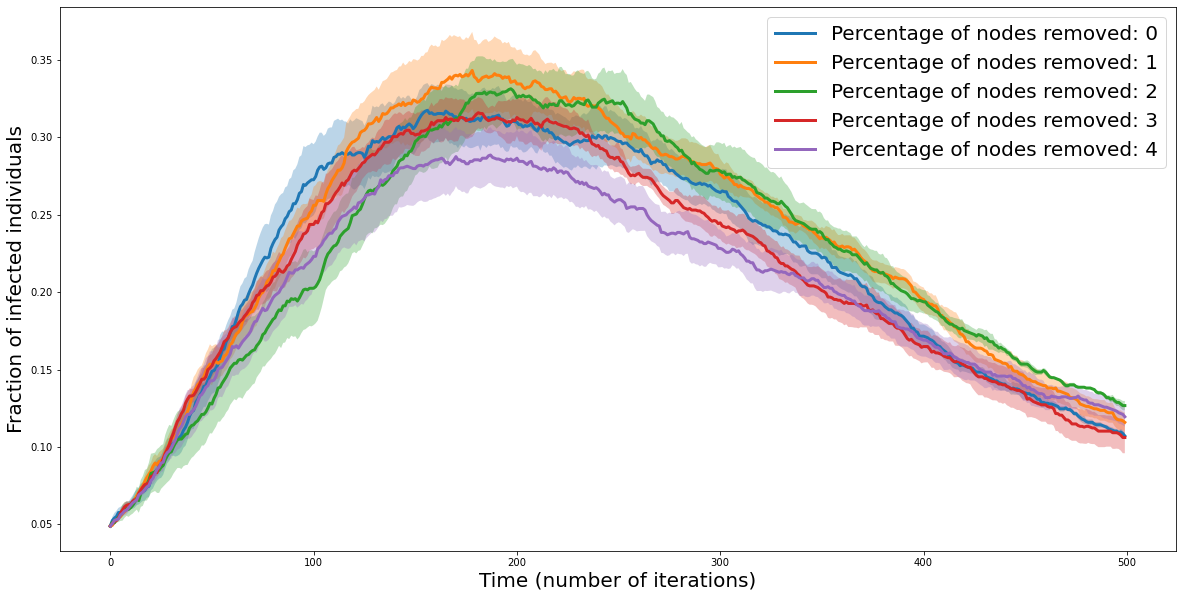

In [133]:
fig, ax = plt.subplots(figsize=a4_dims)

plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

perc = [0,1,2,3,4]
no_experiments = 5

ranks = keys_ei

for i in range(5):
    H = G.copy()
    number = round(float(perc[i])*G.number_of_nodes()/100)
    top_nodes = ranks[:number]
    for n in top_nodes:
        H.remove_edges_from([(n,out) for out in G.neighbors(n)])
    experiments = np.zeros((no_experiments,500),dtype=float)
    for ex in range(no_experiments):
        curve = get_SIR_infection_curve(H, 0.01,0.005, 500)
        experiments[ex]=curve[1]
    avg = np.mean(experiments,axis=0)
    std = np.std(experiments,axis=0)
    ax.plot(curve[0],avg, label = 'Percentage of nodes removed: '+str(perc[i]), linewidth = 3)
    ax.fill_between(curve[0],avg-0.5*std, avg + 0.5*std, alpha = 0.3)
    
plt.legend(loc = 'upper right', fontsize=20)
plt.show()

# For Location ID & Users

In [116]:
# Grouping the data
grouped_df_E = data_final.groupby(["Check_In_Date", "Time Intervals", "Location id", "User"])
grouped_df_E = pd.DataFrame(grouped_df_E.size().reset_index(name = "Group_Count"))
#display(grouped_df_E)

# Initializing the list
final_data_ = []
tupl_lo = []

# Extracting the grouped UserID's and storing it as list 
records = grouped_df_E[["Location id", "User"]].to_records(index=False)
print(records)
result = list(records)
#print(result)

[(  9410,  302) (  9410, 3380) (  9410, 3434) ( 10259, 3434)
 ( 10259, 4564) (  9410, 4794) ( 19542, 5829) ( 19542, 7525)
 ( 10259, 3978) (  9410,  266) (  9410, 8752) ( 19542, 6506)
 (  9241, 4216) (  9241, 6303) (  9410, 5454) (  9410, 5717)
 ( 10259, 1351) ( 10259, 2899) ( 10259, 3129) ( 19542,  510)
 ( 19542, 3425) ( 19542, 3582) ( 19542, 4137) ( 19542, 7756)
 ( 19542, 9497) (  9241, 5739) (  9410,  350) ( 10259, 2854)
 ( 10259, 3299) ( 10259, 4875) ( 19542,   85) ( 19542, 2244)
 (  9241, 2278) (  9241, 3328) (  9410, 1851) (  9410, 5743)
 ( 10259, 4807) ( 10259, 5743) ( 19542,   86) ( 19542,  179)
 (  9410,  141) ( 19542,  476) ( 19542, 5048) (  9410,  515)
 ( 10259,  515) ( 10259, 6152) ( 10259, 6153) (  9410, 1543)
 (  9410, 3992) ( 10259,  536) ( 19542, 5877) ( 19542, 6320)
 (  9241, 3002) (  9241, 3030) (  9241, 4216) (  9241, 5739)
 (  9410, 4794) ( 10259, 4712) ( 19542, 4383) (  9241, 3806)
 (  9241, 5739) (  9410,  282) (  9410, 6546) ( 10259,  282)
 ( 10259,  283) ( 10259,

In [118]:
df_lo = pd.DataFrame(records, columns = ["Location id", "User"])
df_lo = df.groupby(["Location id", "User"]).size().reset_index(name='count')
#Weight_nodes = Weight_nodes.astype(int)

*Plotting the Graph*

{9241: Text(0.04268511118814093, -0.18815906012469155, '9241'),
 0: Text(0.0049938332973895275, -0.1767400732736756, '0'),
 41: Text(-0.019470975470492407, -0.2000085031885445, '41'),
 52: Text(0.00031993607060472605, -0.18369783203851855, '52'),
 66: Text(0.011869630337048173, -0.26805686810486995, '66'),
 88: Text(0.0030789669426269277, -0.14263989120714354, '88'),
 141: Text(0.0014706558007032886, -0.15113283310680595, '141'),
 153: Text(0.018752331814393296, -0.27663866761083883, '153'),
 172: Text(0.08524195111477971, -0.26280474295331496, '172'),
 197: Text(-0.026447111023706123, -0.02520311544756962, '197'),
 267: Text(0.1081444384564012, -0.23229089893138566, '267'),
 312: Text(-0.03940784254449663, -0.03895784375317287, '312'),
 335: Text(0.10301636059628315, -0.2605163964148667, '335'),
 375: Text(0.05211734806185481, -0.2659475510716796, '375'),
 419: Text(0.08474476707911228, -0.2256462865300434, '419'),
 434: Text(-0.0055738746545190435, -0.17400371762479566, '434'),
 515:

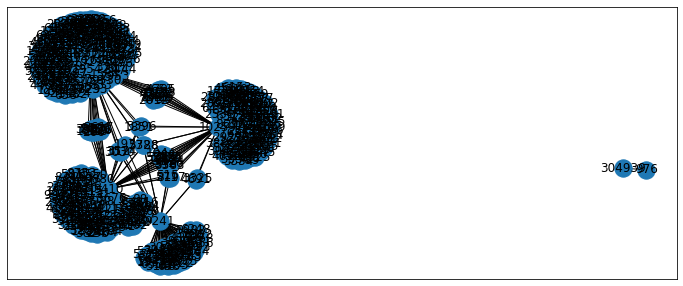

In [119]:
G_loc = nx.from_pandas_edgelist(df_lo,'Location id','User', edge_attr='count')
durations = [i['count'] for i in dict(G_loc.edges).values()]
labels = [i for i in dict(G_loc.nodes).keys()]
labels = {i:i for i in dict(G_loc.nodes).keys()}

fig, ax = plt.subplots(figsize=(12,5))
pos = nx.spring_layout(G_loc)
nx.draw_networkx_nodes(G_loc, pos, ax = ax)
nx.draw_networkx_edges(G_loc, pos, width=durations, ax=ax)
nx.draw_networkx_labels(G_loc, pos, labels, ax=ax)

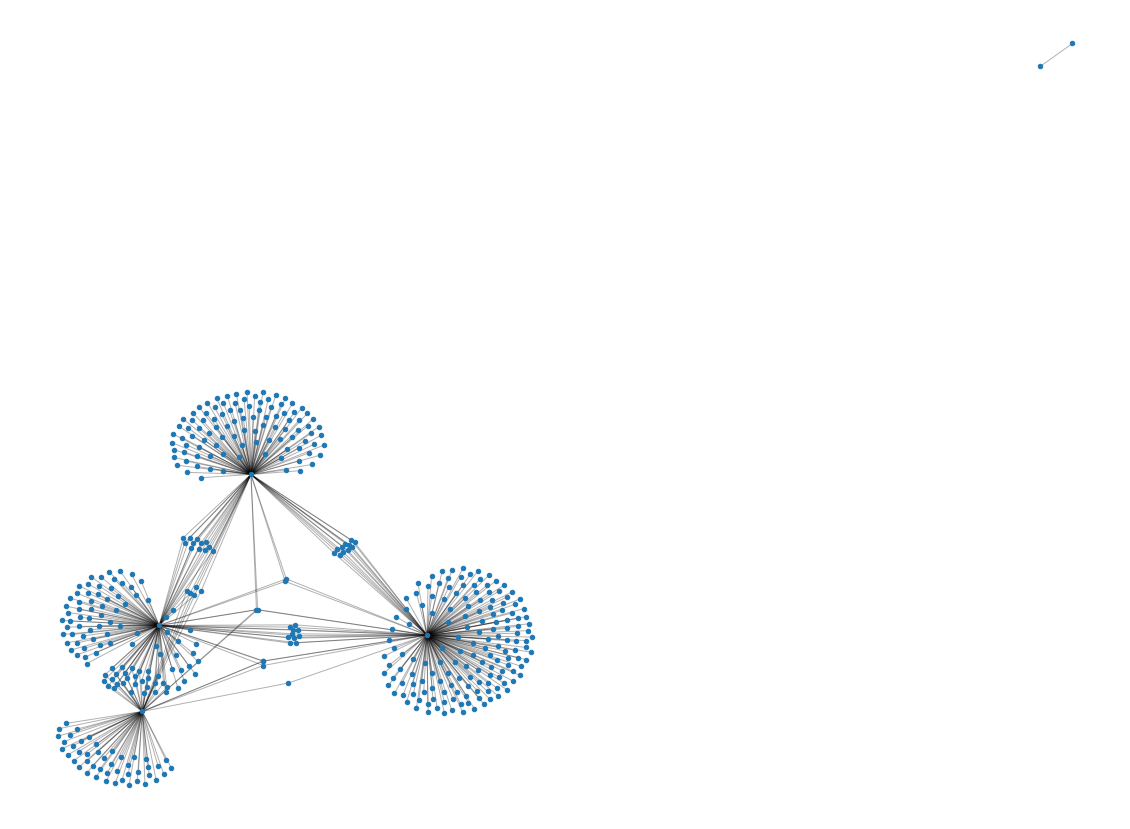

In [123]:
a4_dims = (20, 15)
fig, ax = plt.subplots(figsize = a4_dims)
plt.axis('off')
pos = nx.spring_layout(G_loc)
nx.draw_networkx_nodes(G_loc, pos, node_size=20)
nx.draw_networkx_edges(G_loc, pos, alpha = 0.3)
plt.show()

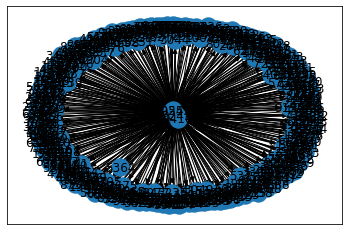

In [127]:
# store pairs to a list of tuples
G_dir = nx.from_pandas_edgelist(df_lo, 'Location id', 'User', create_using=nx.DiGraph())

# set up a graph and show it
#G = nx.DiGraph()
#G.add_edges_from(tuples)
nx.draw_networkx(G)
plt.xticks([], [])
plt.yticks([], [])
plt.show()

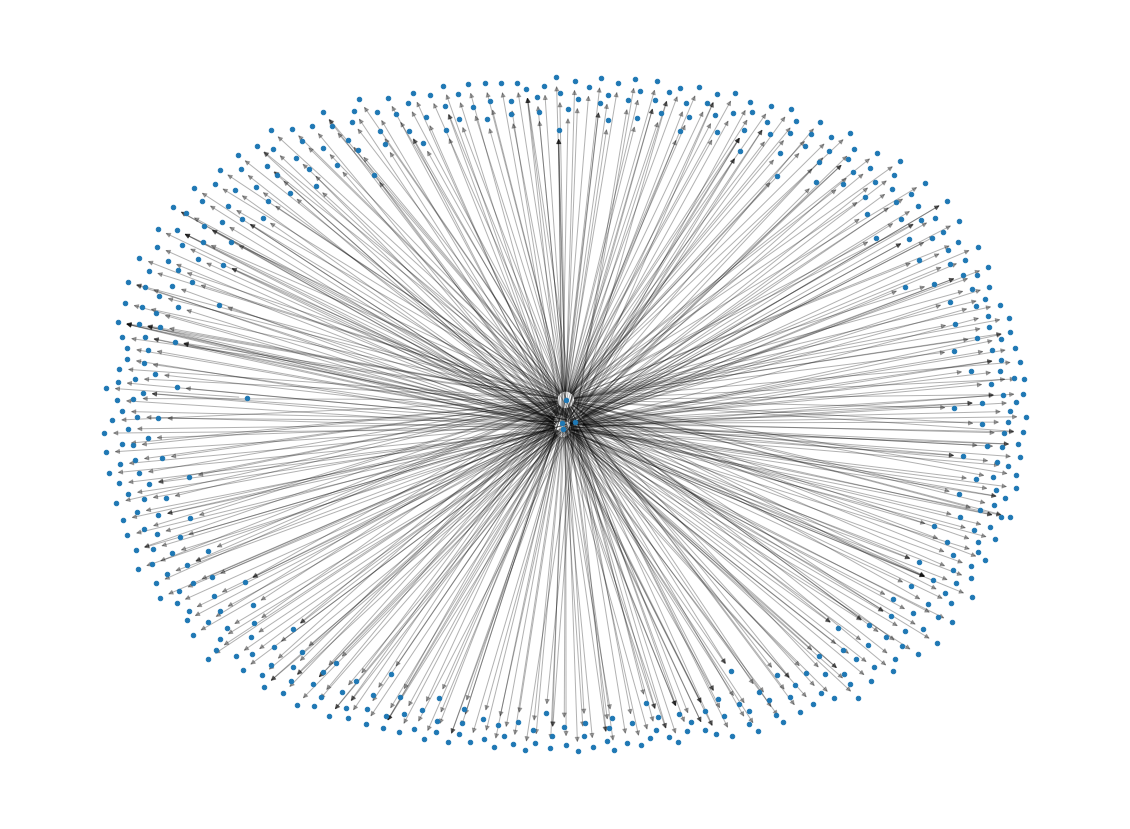

In [128]:
a4_dims = (20, 15)
fig, ax = plt.subplots(figsize = a4_dims)
plt.axis('off')
pos = nx.spring_layout(G_dir)
nx.draw_networkx_nodes(G_dir, pos, node_size=20)
nx.draw_networkx_edges(G_dir, pos, alpha = 0.3)
plt.show()